In [ ]:
import os
import sys
sys.path.append("./src")
from soil_models import *
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from scipy.ndimage import gaussian_filter1d


matplotlib.rcParams.update({'font.size': 16})

data_dir='/fd1/QibinShi_data/England_farm/'
psd_data = os.path.join(data_dir, 'psd_all.hdf5')
harper_met = 'data/NewportSalop_merged.csv'
reg_met = 'data/met_newport.csv'



![Farm Picture](farm_pic.png)

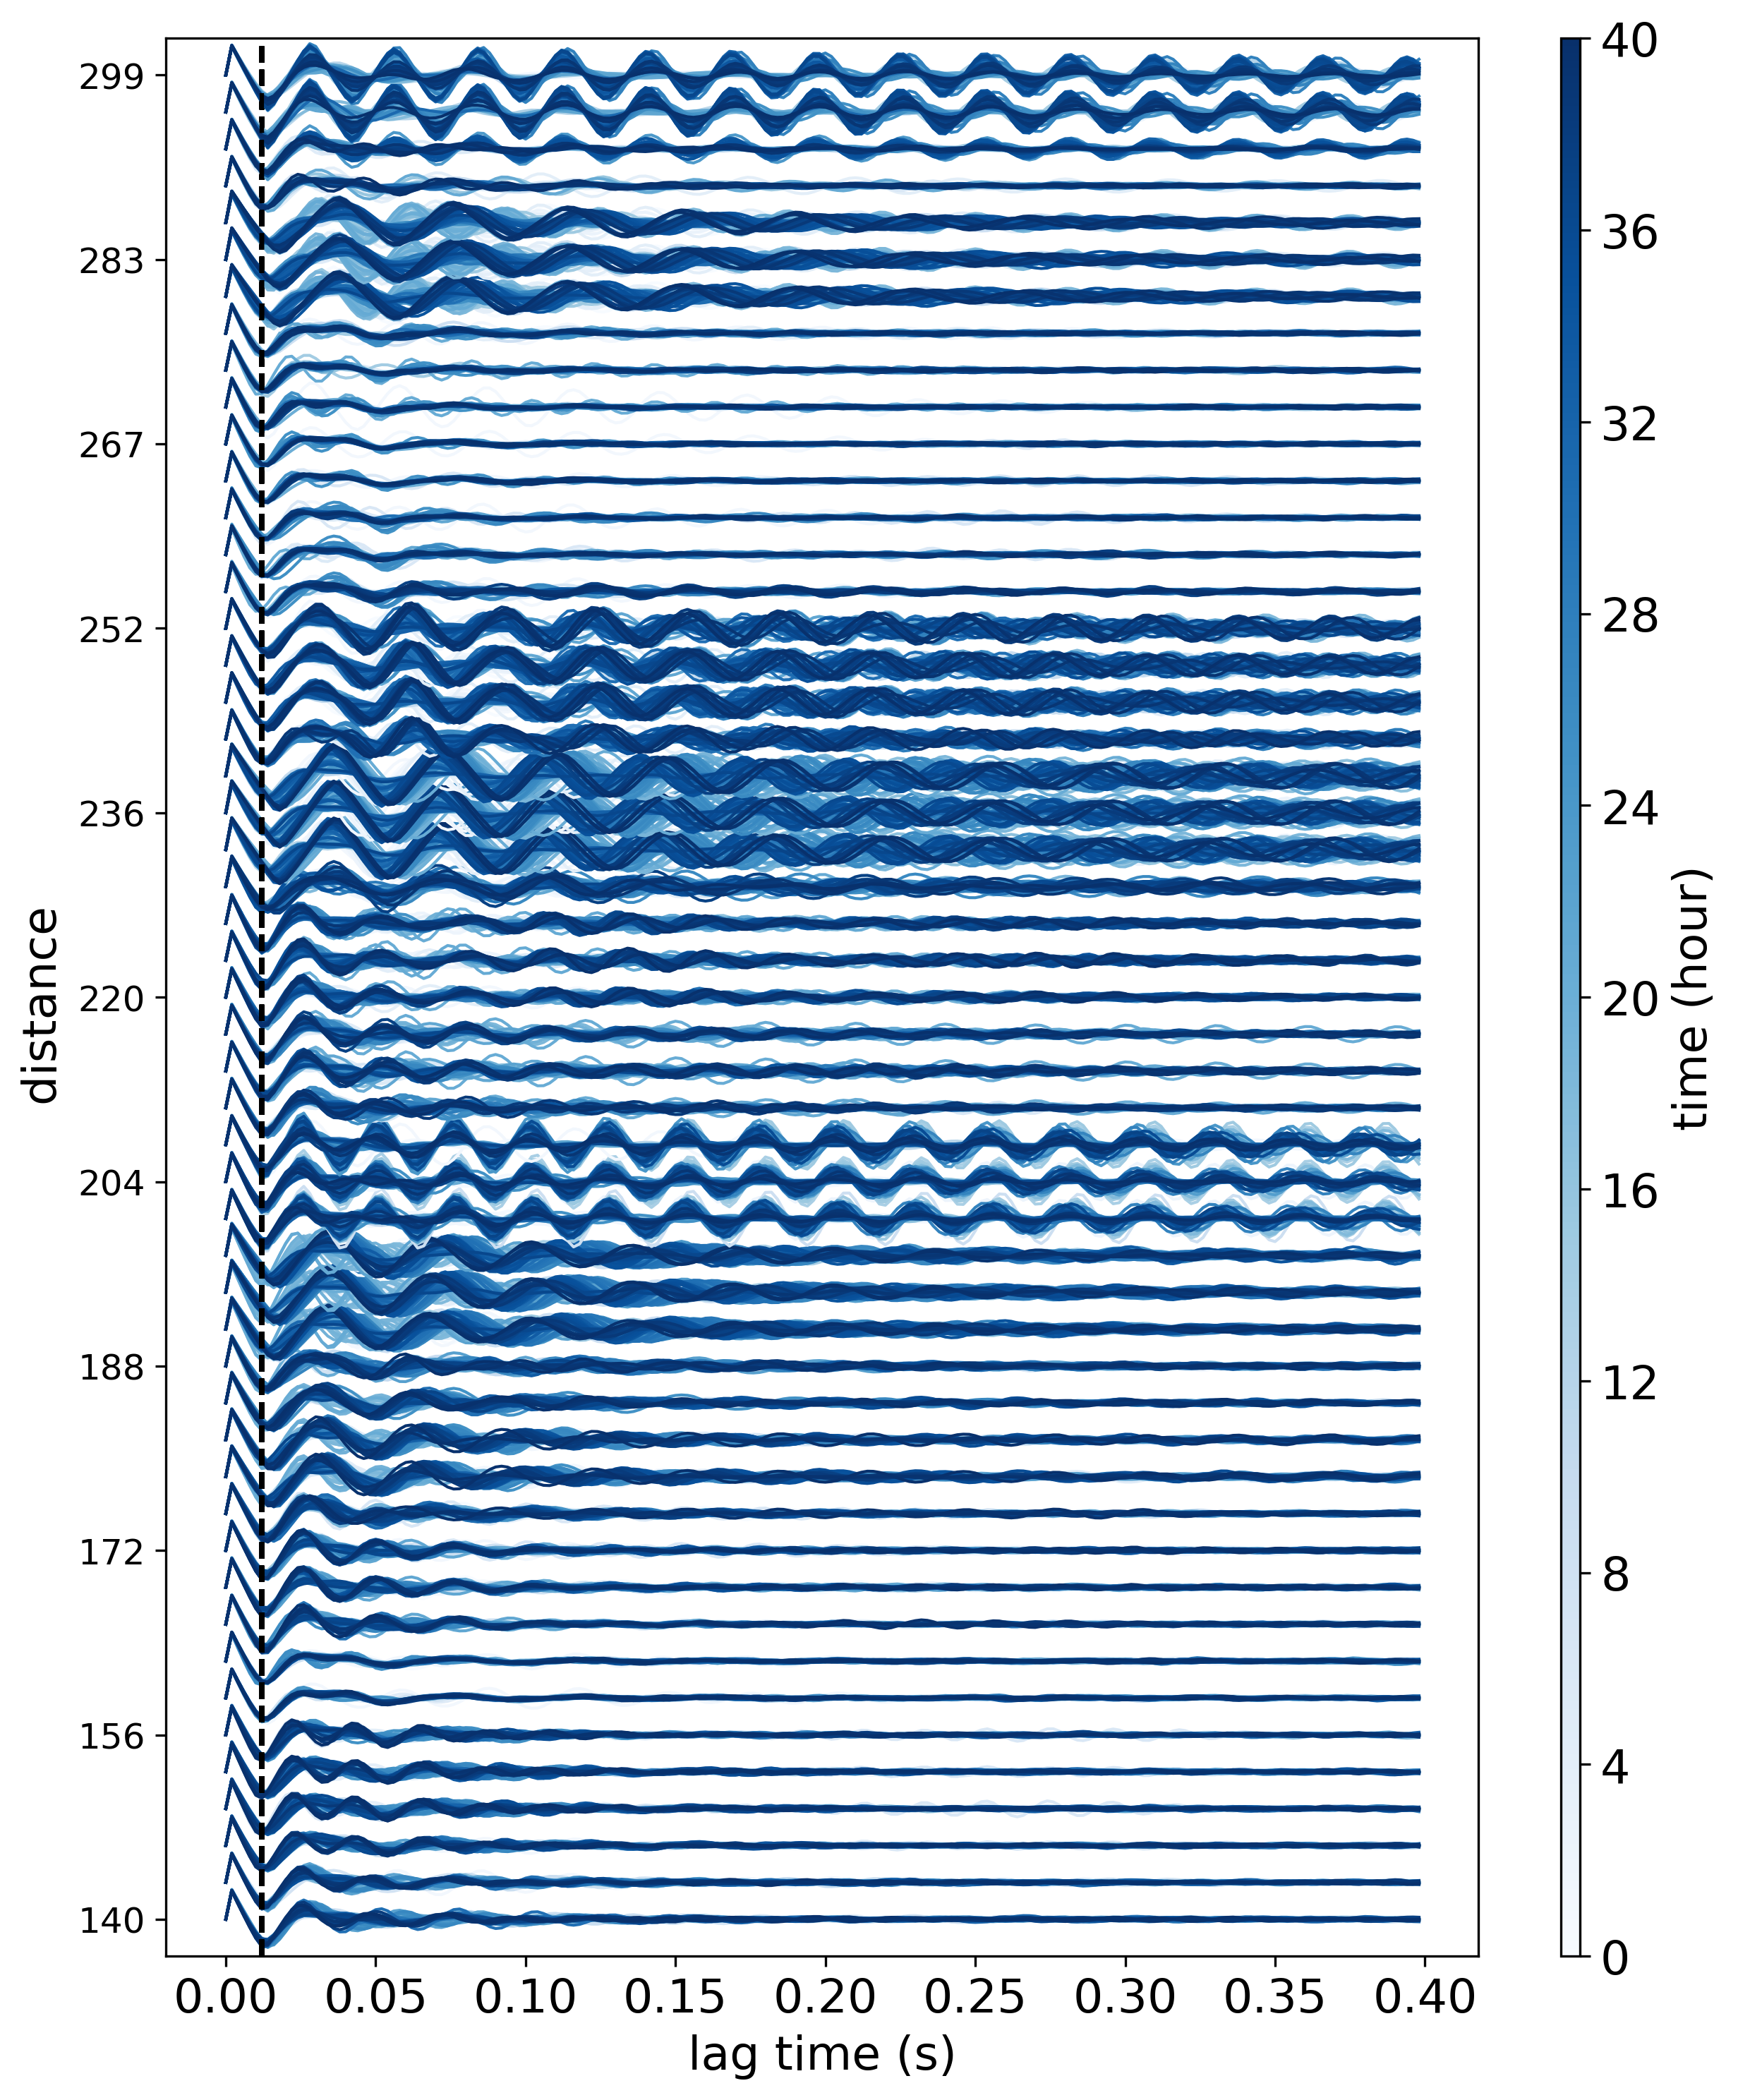

In [4]:
samp_freq = 500
win_st = int(0.012*samp_freq)

with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_25_50Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:, :, 2500:2700, 0]
    
plt.figure(figsize = (10, 12), dpi = 300)
# plt.xlim(0, 0.1)
plt.ylim(43, 95)
plt.ylabel('distance ', fontsize=16)
for iloc in np.arange(0,51,1):
    data_plot=corr_all_time[iloc].T
    x=np.arange(data_plot.shape[1])
    y=np.arange(data_plot.shape[0])

    
    for i in x[::5]:
        plt.plot(y/samp_freq, data_plot[:,i]*1.1+iloc+44, color=plt.cm.Blues(i / len(x)), lw=1)

    # plt.plot(y/samp_freq, np.mean(data_plot+iloc, axis=1), c='k', lw=9, alpha=0.3)

    plt.xlabel('lag time (s)')
    plt.axvline(x=win_st/samp_freq, color='k', linestyle='--', label='1st reflection')

plt.yticks(np.arange(44,95,5), (np.arange(44,95,5)*3.19).astype(int), fontsize = 12)
# plt.xlim(0.005, 0.1)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='time (hour)', aspect=100)
cbar.set_ticks(np.linspace(0, 1, num=11))
cbar.set_ticklabels(np.linspace(0, 40, num=11).astype(int))


## Inversions

### Step 1: lithological

In [19]:
## Forward model predicting next-minute velocity
class litho_1:
    def __init__(self, bulk_density, porosity, N, f, s0, s_rate, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s0 = s0  ## Saturation from the previous minute
        self.s_rate = s_rate ## rate per sec
        self.s = self.s0 + self.s_rate * 60 ## Saturation at the current minute
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            P_cdiff = self.s_rate * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5
        

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)
    

        return self.vp, self.vs, self.K, self.G, self.rho, self.s

<ipython-input-19-dd622d45bf61>:43: RuntimeWarning: invalid value encountered in scalar power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


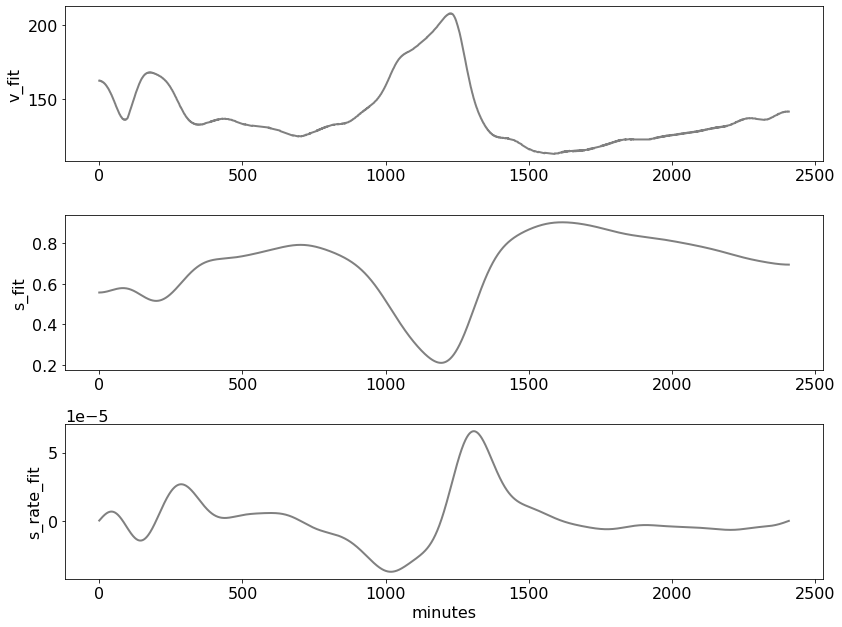

In [20]:
s0 = 0.5
v = []
s_rate_inv = []
s_inv = []

dvv = dvv_all[18]
dvv_smooth = gaussian_filter1d(dvv, sigma=30, mode='reflect')

for i in range(2408):
    ds_space = np.arange(-0.02, 0.02, 0.0001)
    obj_func = np.zeros_like(ds_space)
    vs_clay = np.zeros_like(ds_space)
    s_rates = np.zeros_like(ds_space)
    for ii, ds in enumerate(ds_space):
        s = ds  + s0
        if s < 0:
            s = 0
        if s > 1:
            s = 1
        s_rates[ii] = (s - s0) / 60
        
        scale_factor = (s+1)/2 * 3 - 0.6
        new_f = 0.9-scale_factor/2

        if s_rates[ii] > 0:
            tau = 5e6 * np.exp(np.power(s,3))  ## wetting
        else:
            tau = 1e7 * (1-s)  ## drying

        _, vs_clay[ii],   _, _, _, _ = litho_1(bulk_density, porosity, 8, new_f, s, s_rates[ii], s_wr, tau).get_vp_vs()
        obj_func[ii] = (dvv_smooth[i]*135 - vs_clay[ii]) ** 2

    best_idx = np.argmin(obj_func)
    if np.isnan(vs_clay[best_idx]):
        best_idx = np.nanargmin(obj_func)

    s = s0 + s_rates[best_idx] * 60
    scale_factor = (s+1)/2 * 3 - 0.6
    new_f = 0.9-scale_factor/2

    if s_rates[ii] > 0:
        tau = 5e6 * np.exp(np.power(s,3))  ## wetting
    else:
        tau = 1e7 * (1-s)  ## drying


    _, vs_best,   _, _, _, s0 = litho_1(bulk_density, porosity, 8, new_f, s, s_rates[best_idx], s_wr, tau).get_vp_vs()

    v.append(vs_best)
    s_rate_inv.append(s_rates[best_idx])
    s_inv.append(s0)

s_inv_smooth = gaussian_filter1d(s_inv, sigma=60, mode='reflect')
s_rate_inv_smooth = np.append(np.diff(s_inv_smooth) / 60, [0])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)

# Plot v_fit
ax1.plot(np.arange(2408), v, label='v_fit', color='gray', lw=2)
ax1.set_ylabel("v_fit", fontsize=16)

# Plot s_rate_fit
ax2.plot(np.arange(2408), s_inv_smooth, label='s_fit', color='gray', lw=2)
ax2.set_ylabel("s_fit", fontsize=16)

# Plot s_fit
ax3.plot(np.arange(2408), s_rate_inv_smooth, label='s_rate_fit', color='gray', lw=2)
ax3.set_ylabel("s_rate_fit", fontsize=16)
ax3.set_xlabel("minutes", fontsize=16)

plt.show()


### Step 2: hydrological

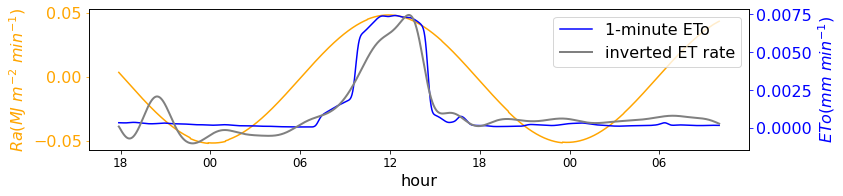

In [21]:
### Backward model using s_history to calculate the ET rate
class hydro1:
    def __init__(self, prec, s_inv, s_rate_inv, damage_index, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s_inv
        self.s_rate = s_rate_inv
        self.damage = damage_index
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length


    def get_evap(self):
        prec_rate = self.A_p * self.prec

        ## drainage
        drain_rate = self.A_d * self.prec * self.s * self.damage  ## Drainage rate

        evap_rate = prec_rate - drain_rate - self.s_rate

        ## evaporation
        self.evap = evap_rate / self.A_e 
        self.etc = self.evap / (self.s * self.damage) ## Evaporation rate
        
        return self.etc
    

A_e = 1
A_d = 0.1
A_p = 0.22

psd_smooth = gaussian_filter1d(ave_psd*2, sigma=60, mode='reflect')
etc_rate = hydro1(psd_smooth, s_inv_smooth, s_rate_inv_smooth * 60, damage_index[10], A_p,A_e,A_d).get_evap()
etc_smooth = gaussian_filter1d(etc_rate, sigma=1, mode='reflect')
eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=10, mode='reflect')

fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation', color='orange')
ax1.set_xlabel("hour", fontsize=16)
ax1.set_ylabel("$Ra (MJ~m^{-2}~min^{-1})$", fontsize=16, color='orange')
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.tick_params(axis='y', colors='orange')

ax2 = ax1.twinx()
ax2.plot(np.arange(acqu_time.shape[0]), eto_every_minute_smooth, label='1-minute ETo', color='blue')
ax2.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16, color='blue')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.plot(np.arange(2408), etc_smooth, label='inverted ET rate', color='gray', lw=2)

plt.legend()

fig.tight_layout()
plt.show()

1492
5.873158925865117 0.10983544713091575


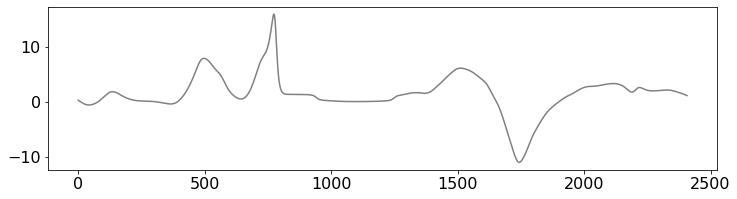

In [66]:

### Backward model using s_history to calculate the Damage index
class hydro2:
    def __init__(self, prec, s_inv, s_rate_inv, etc, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s_inv
        self.s_rate = s_rate_inv
        self.etc = etc
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length


    def get_damage(self):
    
        self.damage = (self.A_p * self.prec  - self.s_rate) / self.s / (self.A_e * self.etc + self.A_d * self.prec)

        i_peak_loss_rate = np.argmin(self.s_rate)
        print(i_peak_loss_rate)

        return self.damage, self.damage[i_peak_loss_rate]
    

A_e = 1
A_d = 0.1
A_p = 0.22

psd_smooth = gaussian_filter1d(ave_psd*2, sigma=60, mode='reflect')
damage_index, damage_index_peak = hydro2(psd_smooth, s_inv_smooth, s_rate_inv_smooth * 60, eto_every_minute_smooth, A_p,A_e,A_d).get_damage()
plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), damage_index, label='damage index', color='gray')
print(damage_index_peak, np.median(damage_index[1000:1300]))